imports

In [7]:
import torch
import matplotlib.pyplot as plt

In [8]:
class model:
    def __init__(self, x, y):
        self.x = x
        self.y = y

        self._initalize_parameters()
        self._initalize_moms()
        self._initalize_RMSs()

    def _initalize_parameters(self):
        self.weights_1 = self._random_tensor((x.shape[1],3))
        self.bias_1 = self._random_tensor(1)
        self.weights_2 = self._random_tensor((3,1))
        self.bias_2 = self._random_tensor(1)

    def _random_tensor(self, size): return (torch.randn(size)).requires_grad_()

    def _initalize_moms(self):
        self.moms_w1, self.moms_b1 = [0], [0]
        self.moms_w2, self.moms_b2 = [0], [0]

    def _initalize_RMSs(self):
        self.RMSs_w1, self.RMSs_b1 = [0], [0]
        self.RMSs_w2, self.RMSs_b2 = [0], [0]
    def _nn(self, xb):
        l1 = xb @ self.weights_1 + self.bias_1
        l2 = l1.max(torch.tensor(0.0))
        l3 = l2 @ self.weights_2 + self.bias_2
        return l3

    def _loss_func(self, preds, yb):
        return ((preds-yb)**2).mean()

    def train(self, optimizer):
        # Multiple learning rates to see how optimizers work with them
        lrs = [10E-4,10E-3,10E-2,10E-1]
        ## for plotting ##
        fig, axs = plt.subplots(2,2)
        ## for plotting ##
        all_losses = []
        for i, lr in enumerate(lrs):
            losses = []
            while(len(losses) == 0 or losses[-1] > 0.1 and len(losses) < 1000):
                preds = self._nn(self.x)
                loss = self._loss_func(preds, self.y)
                loss.backward()
                optimizer(self.weights_1, lr, self.moms_w1, self.RMSs_w1)
                optimizer(self.bias_1, lr, self.moms_b1, self.RMSs_b1)
                optimizer(self.weights_2, lr, self.moms_w2, self.RMSs_w2)
                optimizer(self.bias_2, lr, self.moms_b2, self.RMSs_b2)
                losses.append(loss.item())
            all_losses.append(losses)

            ## for plotting ##
            xi = i%2
            yi = int(i/2)
            axs[xi,yi].plot(list(range(len(losses))), losses)
            axs[xi,yi].set_ylim(0, 30)
            axs[xi,yi].set_title('Learing Rate: '+str(lr))
            ## for plotting ##

            # Setting seed makes sure the parameters are initalized the same way for better comparison
            torch.manual_seed(42)
            self._initalize_parameters()
            self._initalize_moms()
            self._initalize_RMSs()

        ## for plotting ##
        for ax in axs.flat:
            ax.set(xlabel='steps', ylabel='loss (MSE)')
        plt.tight_layout()
        ## for plotting ##

This simple function is implemented to generate y values from x values.

In [9]:
def generate_fake_labels(x3, x2, x1):
    return (x3**3 * 0.8) + (x2**2 * 0.1) + (x1 * 0.5) + 4.

In [10]:
x = torch.tensor([[0.7,0.3,0.7],
                  [0.4, 1., 0.4],
                  [0.2, 1.1, 0.1],
                  [0.4, 0.7, 0.2],
                  [0.1, 0.5, 0.3]])
y = torch.tensor([generate_fake_labels(i[0],i[1],i[2]) for i in x])
print(x.shape, y.shape, y)

torch.Size([5, 3]) torch.Size([5]) tensor([4.6334, 4.3512, 4.1774, 4.2002, 4.1758])


In [11]:
y = torch.tensor([4.6334, 4.3512, 4.1774, 4.2002, 4.1758])

In [12]:
my_model = model(x, y)

Below are a few optimizer functions. Use them for the given model and Compare and report their results.

In [13]:
def SGD(a, lr, _, __):
    a.data -= a.grad * lr
    a.grad = None

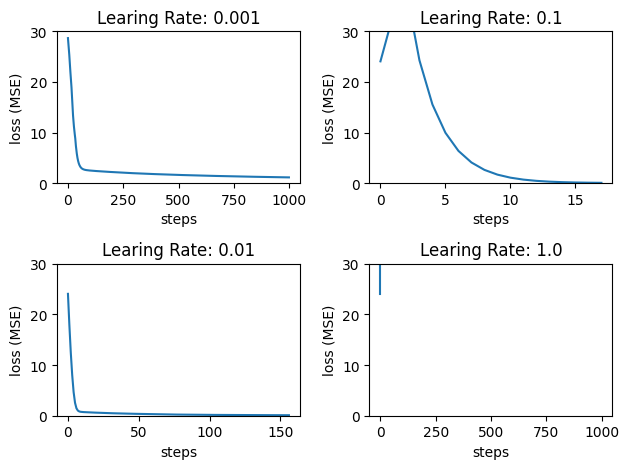

In [14]:
#train model with SGD
my_model.train(SGD)

The results with plain SGD show that the learning rate has a very strong effect on how quickly and how smoothly the model converges. With a small learning rate like 0.001 the loss decreases slowly but steadily and eventually reaches a low value after many steps, while with 0.01 the model converges much faster in only a few dozen updates. At 0.1 the optimizer still converges but with a sharper curve, indicating that the step size is close to the limit of stability. When the learning rate is set to 1.0 the training becomes unstable and the loss fails to decrease, showing that the optimizer cannot handle such a large step size. Overall, SGD is simple and works reliably at moderate learning rates, but it can be inefficient when the learning rate is too small and unstable when the learning rate is too large.

In [15]:
def momentum(a, _, moms, __):
    previous_momentum = moms[-1]

    mom = a.grad * 0.1 + previous_momentum * 0.9
    moms.append(mom)
    a.data -= mom
    a.grad = None

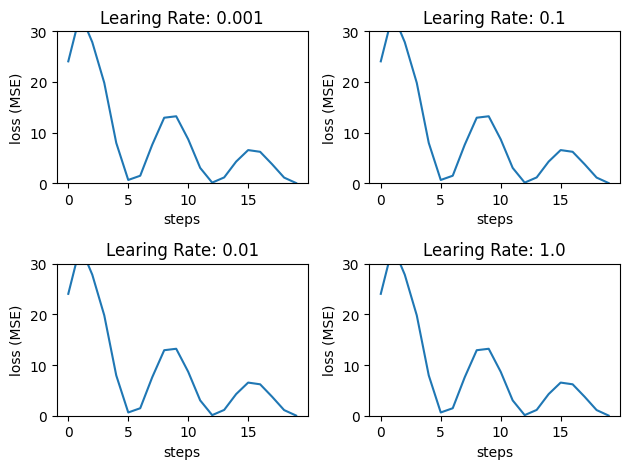

In [16]:
#train model with momentum
my_model.train(momentum)

The momentum runs converge faster than plain SGD but show strong oscillations: the loss drops sharply, then repeatedly spikes and dips before settling. That ringing comes from the update using a heavy carry-over of the previous step. Also, in the code the learning-rate argument isn’t used at all—momentum(a, _, moms, __) ignores lr and hardcodes the step as a.grad * 0.1 + previous_momentum * 0.9, so all four plots behave almost the same despite the different Learning Rate labels. In effect, the real step size is driven by those two constants (0.1 for the new gradient and 0.9 for the momentum), which explains the aggressive, under-damped trajectory. If we want smoother, more stable curves, we have to either incorporate lr into the update (e.g., scale the whole step by lr) or reduce the momentum factor or the gradient coefficient to damp the overshoot.

Comparing:

When comparing the results of plain SGD and the momentum version, the differences are clear. With SGD the effect of the learning rate is obvious: a small rate leads to slow but smooth convergence, a moderate rate converges quickly, and a very large rate becomes unstable. In contrast, the momentum implementation in the code shows almost the same behavior across all learning rates because the update rule does not actually use the lr argument. Instead, it combines the gradient with a fixed weight of 0.1 and the previous momentum with 0.9, which causes the loss curves to oscillate strongly before eventually decreasing. This makes momentum appear faster at first glance, because the loss can drop to near zero in only a few steps, but the overshooting and repeated spikes reduce stability. Overall, SGD gives more predictable and controllable behavior depending on the chosen learning rate, while the momentum version as written converges faster but is less stable and not sensitive to the learning rate setting.